In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [4]:
train_2016 = pd.read_csv("train_2016_v2.csv", header = 0)
train_2017 = pd.read_csv("train_2017.csv", header = 0)
properties_2016 = pd.read_csv("properties_2016.csv", header = 0)
properties_2017 = pd.read_csv("properties_2017.csv", header = 0)

print(train_2016.shape)
print(train_2017.shape)
print(properties_2016.shape)
print(properties_2017.shape)

(90275, 3)
(77613, 3)
(2985217, 58)
(2985217, 58)


In [6]:
# make 2016 and 2017 merged data
data2016 = pd.merge(train_2016, properties_2016, how = 'left', on = 'parcelid')
data2017 = pd.merge(train_2017, properties_2017, how = 'left', on = 'parcelid')

print(data2016.shape)
print(data2017.shape)

(90275, 60)
(77613, 60)


In [7]:
# final merged data
data = pd.concat([data2016, data2017], axis = 0)
data.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


In [8]:
# calcuate missing %
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_ratio

buildingclasstypeid             0.999815
finishedsquarefeet13            0.999553
storytypeid                     0.999446
basementsqft                    0.999446
yardbuildingsqft26              0.999017
fireplaceflag                   0.997653
architecturalstyletypeid        0.997212
typeconstructiontypeid          0.996891
finishedsquarefeet6             0.995193
decktypeid                      0.992424
pooltypeid10                    0.990315
poolsizesum                     0.989052
pooltypeid2                     0.986431
hashottuborspa                  0.976746
taxdelinquencyyear              0.972106
taxdelinquencyflag              0.972106
yardbuildingsqft17              0.969986
finishedsquarefeet15            0.960742
finishedfloor1squarefeet        0.923205
finishedsquarefeet50            0.923205
fireplacecnt                    0.893405
threequarterbathnbr             0.868275
pooltypeid7                     0.810731
poolcnt                         0.797037
numberofstories 

In [9]:
to_drop = na_ratio[na_ratio>0.9].index.tolist()
data[to_drop].dtypes

buildingclasstypeid         float64
finishedsquarefeet13        float64
storytypeid                 float64
basementsqft                float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet6         float64
decktypeid                  float64
pooltypeid10                float64
poolsizesum                 float64
pooltypeid2                 float64
hashottuborspa               object
taxdelinquencyyear          float64
taxdelinquencyflag           object
yardbuildingsqft17          float64
finishedsquarefeet15        float64
finishedfloor1squarefeet    float64
finishedsquarefeet50        float64
dtype: object

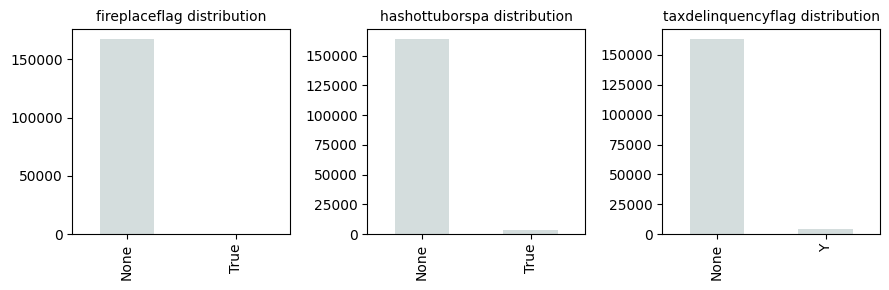

In [10]:
na_obj = data[to_drop].select_dtypes('object').columns # object variables in to_drop list
data[na_obj] = data[na_obj].fillna('None') # value_counts() method does not count NA, so replace it with 'None'

fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9,3))
for i, col in enumerate(na_obj):
    data[col].value_counts().plot.bar(ax = ax[i], color = '#d4dddd')
    ax[i].set_title(f'{col} distribution', fontsize = 10);
plt.tight_layout()
plt.show()

In [12]:
# drop 17 float variables in to_drop
na_float = data[to_drop].select_dtypes('float').columns 
data.drop(na_float, axis = 1, inplace = True)

In [13]:
# dim of data after dropping NA columns
data.shape

(167888, 43)

In [14]:
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_cols = na_ratio[na_ratio>0].index

# ends with 'cnt'
na_cnt = na_cols[na_cols.str.endswith('cnt')]
na_others = na_cols[~na_cols.str.endswith('cnt')]
print(na_cnt)
print('\n')
print(na_others)

Index(['fireplacecnt', 'poolcnt', 'garagecarcnt', 'unitcnt', 'fullbathcnt',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt', 'roomcnt', 'bathroomcnt', 'bedroomcnt'],
      dtype='object')


Index(['threequarterbathnbr', 'pooltypeid7', 'numberofstories',
       'airconditioningtypeid', 'garagetotalsqft', 'regionidneighborhood',
       'heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc',
       'lotsizesquarefeet', 'finishedsquarefeet12', 'regionidcity',
       'calculatedbathnbr', 'yearbuilt', 'calculatedfinishedsquarefeet',
       'censustractandblock', 'regionidzip', 'taxamount',
       'propertycountylandusecode', 'latitude', 'regionidcounty',
       'assessmentyear', 'fips', 'rawcensustractandblock', 'longitude',
       'propertylandusetypeid'],
      dtype='object')


In [15]:
# na_cnt
data[na_cnt] = data[na_cnt].fillna(data[na_cnt].mean())
data[na_others] = data[na_others].fillna(data[na_others].mean())

In [16]:
na_ratio = data.isna().sum().sort_values(ascending = False)/len(data)
na_ratio[na_ratio>0]

propertyzoningdesc           0.352014
propertycountylandusecode    0.000208
dtype: float64

In [17]:
one_col = data.columns[data.nunique()==1]

In [18]:
data.drop(one_col, axis = 1, inplace = True)

In [19]:
data['transactiondate'] = pd.to_datetime(data['transactiondate'], format = '%Y-%m-%d')

data['year'] = data['transactiondate'].dt.year
data['month'] = data['transactiondate'].dt.month
data['day'] = data['transactiondate'].dt.day
data['weekday'] = data['transactiondate'].dt.weekday

data.head(3)

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,year,month,day,weekday
0,11016594,0.0276,2016-01-01,1.000000,2.0,3.0,4.000000,2.0,1684.0,1684.0,...,360170.0,2015.0,237416.0,6735.88,None,6.037107e+13,2016,1,1,4
1,14366692,-0.1684,2016-01-01,1.814345,3.5,4.0,6.015461,3.5,2263.0,2263.0,...,585529.0,2015.0,239071.0,10153.02,None,6.049390e+13,2016,1,1,4
2,12098116,-0.0040,2016-01-01,1.000000,3.0,2.0,4.000000,3.0,2217.0,2217.0,...,119906.0,2015.0,57912.0,11484.48,None,6.037464e+13,2016,1,1,4


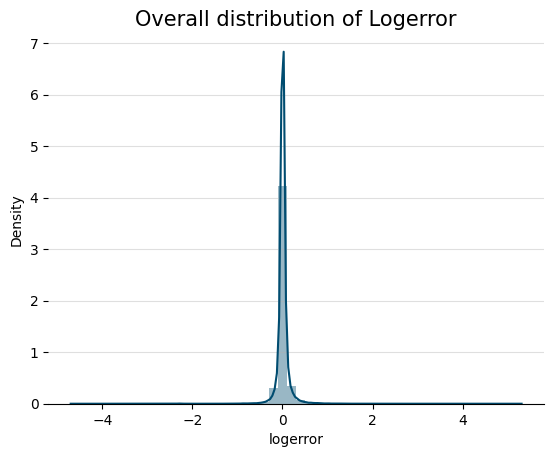

In [20]:
ax = plt.subplot(1,1,1)
sns.distplot(data['logerror'], color = '#004c70')
plt.title('Overall distribution of Logerror', fontsize = 15)

for s in ['top','left','right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

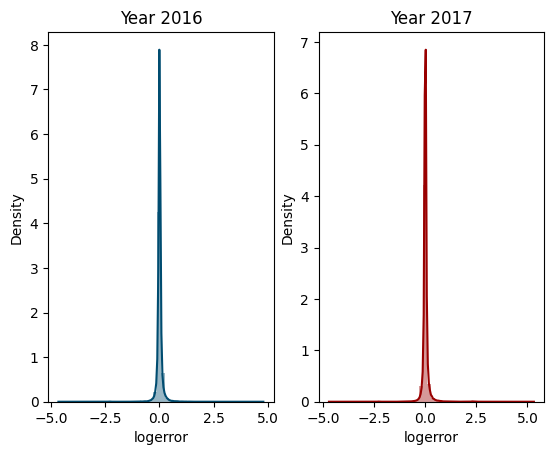

In [21]:
plt.subplot(1,2,1)
sns.distplot(data2016['logerror'], color = '#004c70')
plt.title('Year 2016')
plt.subplot(1,2,2)
sns.distplot(data2017['logerror'], color = '#990000')
plt.title('Year 2017')
plt.show()

) Transaction Date
Monthly Analysis

The first graph shows monthly transaction amount and second one shows monthly mean of logerror. It's interesting to find that monthly transaction amount and monthly mean of logerror shows opposite trend. To be more specific, when there is large transaction amount in certain month, logerror mean tends to be lower than other months. I colored large transaction & lower logerror mean to red, small transaction & higher logerror mean to blue! However, it's hard to conclude that there is correlation between those two yet.
More generally, more transactions occur during spring and summer seasons but transaction amount is comparatively lower in winter seasons(11,12,1,2)

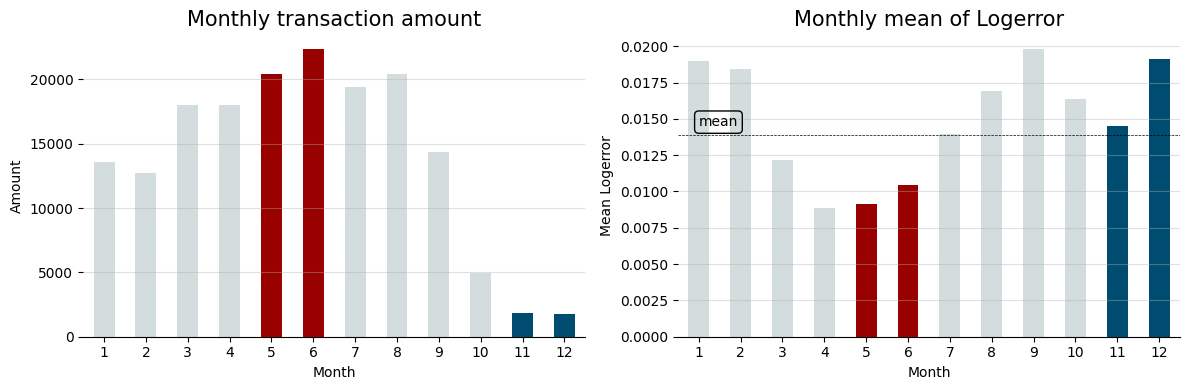

In [22]:
color_map = ['#d4dddd' for _ in range(12)]
color_map[10] = color_map[11] = '#004c70'; color_map[4] = color_map[5] = '#990000'


plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('month')['logerror'].count().plot.bar(color = color_map)
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Amount')
plt.title('Monthly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax2 = plt.subplot(1,2,2)
data.groupby('month')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(0, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Mean Logerror')
plt.title('Monthly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()


Weekly Analysis

Weekly mean logerror comparision plot also shows interesting results. On weekdends(Saturday & Sunday), less transactions occur. It seems that most transactions are done during weekdays.
Weekly mean of logerror on weekends is much lower than other weekdays.

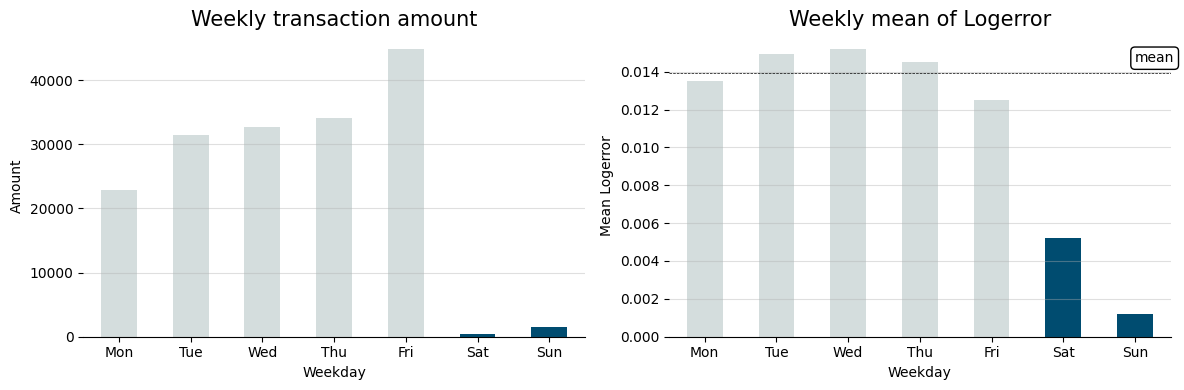

In [23]:
color_map = ['#d4dddd' for _ in range(7)]
color_map[5] = color_map[6] = '#004c70'

plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('weekday')['logerror'].count().plot.bar(color = color_map)
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xticks(rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Amount')
plt.title('Weekly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax = plt.subplot(1,2,2)
data.groupby('weekday')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(6, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Mean Logerror')
plt.title('Weekly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

2) Year Built¶
yearbuilt variable denotes 'the year the principal residence was built'.

Most of residences were built in 100 years, especially from 1950.
Mean logerror is large for residences that were built a long time ago(1824 ~ 1900). Recently built residences have smaller logerrors compared to old ones.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


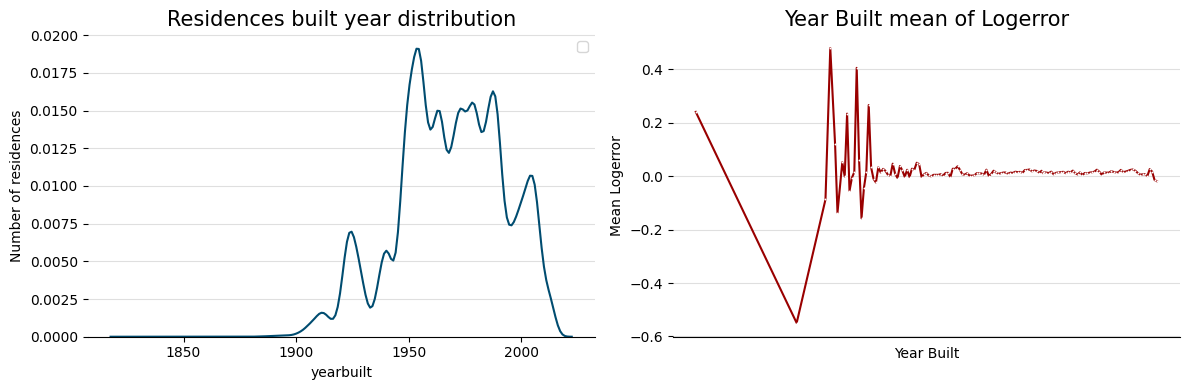

In [24]:
plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
sns.kdeplot(data['yearbuilt'], color = '#004c70');plt.legend(loc='best'); plt.ylabel('Number of residences')
plt.title('Residences built year distribution', fontsize = 15)

# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax2 = plt.subplot(1,2,2)
yearbuilt = data.groupby(['yearbuilt'])['logerror'].mean().reset_index()
sns.lineplot(data = yearbuilt, x = 'yearbuilt', y = 'logerror', marker = 'o', markersize = 0.6, color = '#990000')
plt.xticks([]); plt.xlabel('Year Built'); plt.ylabel('Mean Logerror')
plt.title('Year Built mean of Logerror', fontsize = 15)
# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

(3) Parcel Locations¶
Let's explore location/region related variables! Variables written below are used to plot regions.

longitude & latitude
regions: regionidcounty, regionidcity, regionidzip

In [25]:
# rescale location variables
data[['latitude','longitude']] = data[['latitude','longitude']]/1000000

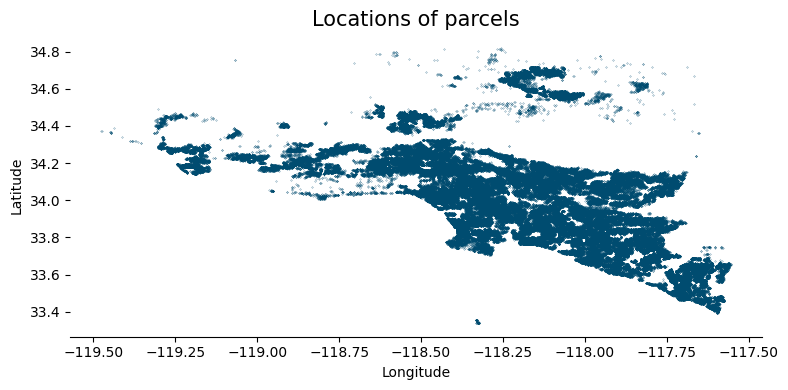

In [26]:
# overall region plot
plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
plt.plot(data['longitude'], data['latitude'], 'o', markersize = 0.2, color = '#004c70')
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Locations of parcels', fontsize = 15)

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

plt.tight_layout()